# Load Data

In [1]:
import music21
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import mnet

In [3]:
'''
Creat local corpus with access pieces
'''

localCorpus = music21.corpus.corpora.LocalCorpus()
localCorpus.addPath('../library')
music21.corpus.cacheMetadata()

s = music21.corpus.parse('telemannfantasie1.xml')
chord_lst = list(s.chordify().recurse().notes)
nodelst = mnet.convert_chord_note(chord_lst, 'A')
g_rn=mnet.create_graph(nodelst)

#write as .gexf
#nx.write_gexf(g_rn, "rn_composition_notechord.gexf")


/opt/anaconda3/envs/music-network-env/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: local metadata cache: starting processing of paths: 1
/opt/anaconda3/envs/music-network-env/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: filename: /var/folders/j6/2q7hftds7vb8_lsfy50l8lzw0000gn/T/music21/local.p.gz
bundles.py: WARNING: MetadataBundle Modification Time: 1588904587.4075384
bundles.py: WARNING: Skipped 1 sources already in cache.
/opt/anaconda3/envs/music-network-env/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: writing time: 0.008 md items: 6

/opt/anaconda3/envs/music-network-env/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: filename: /var/folders/j6/2q7hftds7vb8_lsfy50l8lzw0000gn/T/music21/local.p.gz
caching.py: WARNING: cache: final writing time: 0.009 seconds


## Functions


In [176]:
def generateCommunities(group_dict, graph):
    communityLookup = {}
    for node in group_dict.keys():
        val = group_dict[node]
        if val not in communityLookup.keys():
            communityLookup[val]=set([])
        communityLookup[val].add(node)
    
    subgraphlst=[]
    for label in communityLookup.keys():
        subgraph = graph.subgraph(communityLookup[label])
        subgraphlst.append(subgraph)
    return communityLookup, subgraphlst
        
    
'''
Alters lst in place, gets previous nodes that are not 100% funneled to certain spot
'''
def findpred(graph, edge, lst):
    #print(list(graph.neighbors(edge[0])))    
    
    #the only neighbor, i.e. when node is reached 100% probability of switching communities
    if len(list(graph.neighbors(edge[0]))) == 1:     

        for pred in list(graph.predecessors(edge[0])):
           findpred(graph, (pred, edge[0]), lst)
    else:
           lst.append(edge)
 
'''
Find edges connecting 2 communities where strengthening edge will increase flow
'''
def findBridges(nodeset1, nodeset2):
    bigcom1 = g_info.subgraph(nodeset1)
    bigcom2 = g_info.subgraph(nodeset2)
    bigcom12 = g_info.subgraph(nodeset1  | nodeset2)
    edges = bigcom12.edges- bigcom1.edges-bigcom2.edges
    edgelst1 = []
    edgelst2 = []
    

               
    for edge in edges:
        if edge[0] in nodeset1:
            findpred(bigcom12, edge, edgelst1)
        else:
            findpred(bigcom12, edge, edgelst2)
    return edgelst1, edgelst2


'''
Node to string function that returns melody and list of communities
'''
def str_rn_full_annotated(randomwalk, nodeToGroup_dict):

    mellst = []
    lyriclst = []
    for node in randomwalk:

        mel = node.split()[0]
        n = music21.note.Note(mel)
        n.duration.quarterLength =.5
        lyric= nodeToGroup_dict[node]
        n.lyric = lyric
        lyriclst.append(lyric)
        mellst.append(n)
        
  
    return mellst, lyriclst


def pagerank_analysis(g_rn1):
    
    #generate pagerank
    g_weighted1 = mnet.convert_to_weighted(g_rn1, fraction=False)
    pagerank1 = nx.pagerank(g_weighted1)
    pagerank1_vals = np.sort(np.array([ v for v in pagerank1.values() ]))
    
    #Plot pagerank
    x=np.arange(0, len(pagerank1_vals), 1)
    pagerankplot = [x, pagerank1_vals]
    
    return pagerankplot

def getComOrder(community_lst):
    i=0
    orderlst=[]
    temp = 0
    while i < len(community_lst)-1:
        if community_lst[i] != temp:

            orderlst.append(community_lst[i])
            temp = community_lst[i]
        i += 1
    return orderlst



def countQuantity(orderlst, sections):
    quantitylst=[]
    for s in sections:
        quantitylst.append(np.count_nonzero(orderlst == s))
        
    return quantitylst

def community_freq_analysis(g_rn, community_nodeDictionary, node_communityDictionary, iterations = 50):
    
    sections = list(community_nodeDictionary.keys())
    
    freq_arr = np.zeros(( iterations, len(sections)))
    time_arr = np.zeros(( iterations, len(sections)))
    length_arr = np.zeros(iterations)
    
    #Run 50 random walks
    i = 0
    while i < iterations:
        

        
        randomwalk=mnet.generate_randomwalk(g_rn)
        melody_list, community_lst= str_rn_full_annotated(randomwalk, node_communityDictionary)

        #Get frequency of each section
        orderlst = np.array(getComOrder(community_lst))
        section_freq = countQuantity(orderlst, sections)
        freq_arr[i]=section_freq
        
        #Get time spent in each section
        time_per_section = countQuantity(np.array(community_lst), sections)
        time_arr[i] = time_per_section
        #print(time_per_section)
        
        #Get Length
        length_arr[i]=len(community_lst)
        
        i += 1
        
    freq_average = np.sum(freq_arr, axis=0)/iterations
    time_average = np.sum(time_arr, axis=0)/iterations



    return [sections, freq_average], [sections, time_average], length_arr


## Clustering

In [5]:

g_info = mnet.convert_to_weighted(g_rn, fraction=False)

Assign 'biggroup' and 'smallgroup' 
.net.tree file generated from Infomap web app

In [6]:
bigDict = {}
smallDict = {}
with open("../graphs/rn.net.tree") as tree:
    for line in tree:
        spl = line.split('"')
        node = spl[1]
        path = spl[0].split(':')
        bigGroup=path[0]
        smallGroup=path[0]+path[1]
        #print(node, bigGroup, smallGroup)
        bigDict[node]=bigGroup
        smallDict[node]=smallGroup
        
        
nx.set_node_attributes(g_info, bigDict, 'bigGroup')
nx.set_node_attributes(g_info, smallDict, 'smallGroup')
#nx.write_gexf(g_info, "../graphs/rn_info.gexf")

### Get CommunitytoNode dictionary and group list

In [12]:
c1, sglst1= generateCommunities(bigDict, g_info)

In [13]:
c2, sglst2 = generateCommunities(smallDict, g_info)

## Analyze Original Graph

In [178]:
pagerankplot0 = pagerank_analysis(g_rn)

# Strengthen Edges to Communities 2 and 3

In [16]:
bridge12, bridge21 = findBridges(c1['1'], c1['2'])

In [17]:
bridge13, bridge31 = findBridges(c1['1'], c1['3'])

See fraction of traffic leaving each node

In [20]:
g_fraction=mnet.convert_to_weighted(g_rn, fraction= True)

In [21]:
for el in bridge12:
    print(el, g_fraction.get_edge_data(el[0], el[1])['weight'])

('G4 I', 'D5 IV') 0.5
('A4 Ib753', 'G3 I') 0.3333333333333333


In [22]:
for el in bridge13:
    print(el, g_fraction.get_edge_data(el[0], el[1])['weight'])    

('A4 I', 'E5 V') 0.020833333333333332


### Currently the transition into Community 3 is very unlikely (Will only transition 2% of the time. I will use mnet.degree_increase to increase that probability to 30%

In [23]:
g_rn1 = g_rn.copy()
g_rn1 = mnet.degree_increase(g_rn1, bridge13, 15)
g_rn1 = mnet.degree_increase(g_rn1, bridge12, 10)

In [24]:
g_fraction1=mnet.convert_to_weighted(g_rn1, fraction= True)

In [25]:
for el in bridge13:
    print(el, g_fraction1.get_edge_data(el[0], el[1])['weight'])  

('A4 I', 'E5 V') 0.25396825396825395


In [26]:
for el in bridge12:
    print(el, g_fraction1.get_edge_data(el[0], el[1])['weight'])  

('G4 I', 'D5 IV') 0.9166666666666666
('A4 Ib753', 'G3 I') 0.8461538461538461


### Analysis of Strengthening Connections Between Large Groups

In [122]:
pagerankplot1 = pagerank_analysis(g_rn1)

Analyze Community List - done on random walk

In [132]:
section_freq_graph1, section_time_graph1, len_arr1 = community_freq_analysis(g_rn1, c1, bigDict, 30)

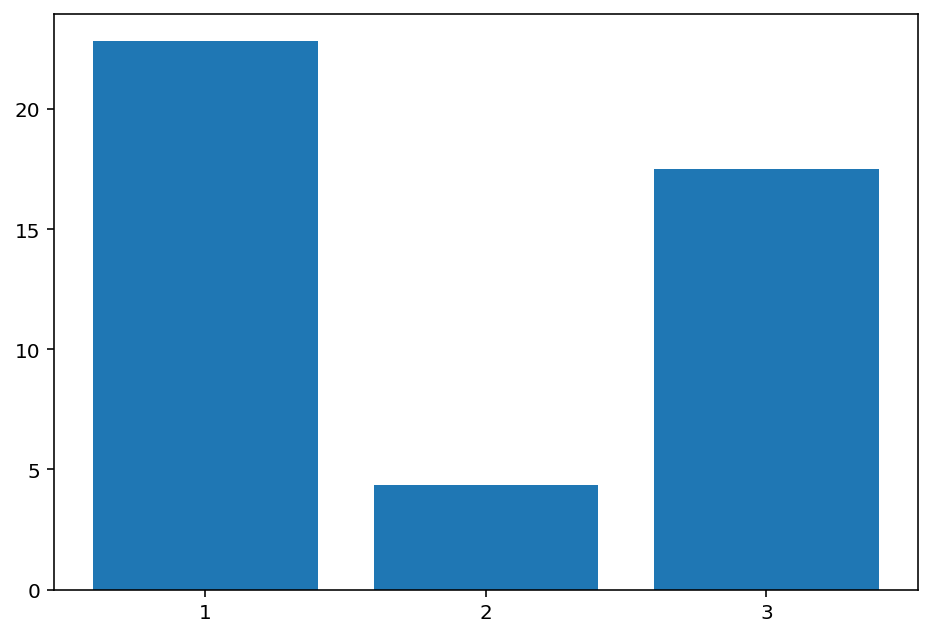

In [141]:
fig, ax = plt.subplots()
plt.title("Community Frequency")
plt.xlabel("Communities")
plt.ylabel("Occurences")
ax = fig.add_axes([0,0,1,1])

ax.bar(section_freq_graph1[0], section_freq_graph1[1])
plt.show()

<Figure size 2160x1440 with 0 Axes>

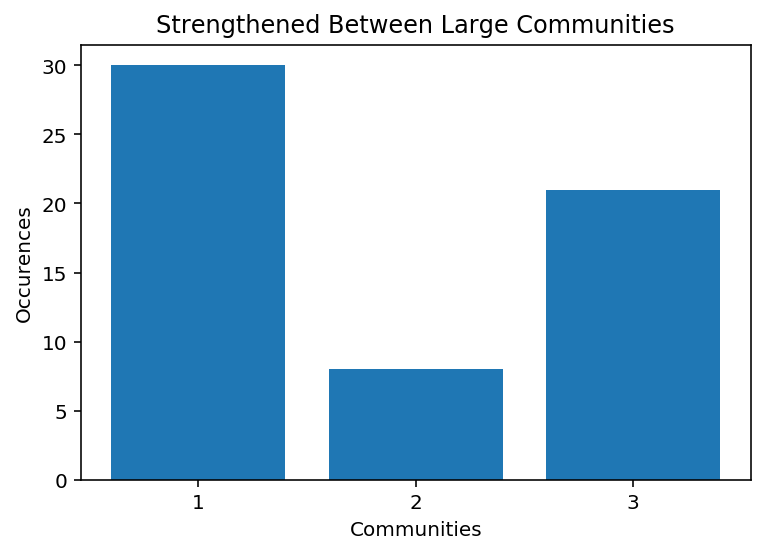

In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
fig, ax = plt.subplots()
plt.title("Strengthened Between Large Communities")
plt.xlabel("Communities")
plt.ylabel("Occurences")
#ax = fig.add_axes([0,0,1,1])

ax.bar(sections1, sectionquantity1)
plt.show()

## Strengthen Sequences

In [143]:
g_rn2 = g_rn.copy()

Sequences usually have 1 less edge than nodes

In [144]:
for subgraph in sglst2:
    if len(list(subgraph.nodes())) - 1 == len(list(subgraph.edges())):
        for node in list(subgraph.nodes):
            if len(list(subgraph.predecessors(node))) == 0: #entrance node
                preds = g_rn2.predecessors(node)
                prededgelst=[]
                for p in preds:
                    prededgelst.append((p, node))
                g_rn2 = mnet.degree_increase(g_rn2, prededgelst, 2)
                    
                
        

In [145]:
nx.write_gexf(g_rn2, "../graphs/rn_communitychange2.gexf")

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

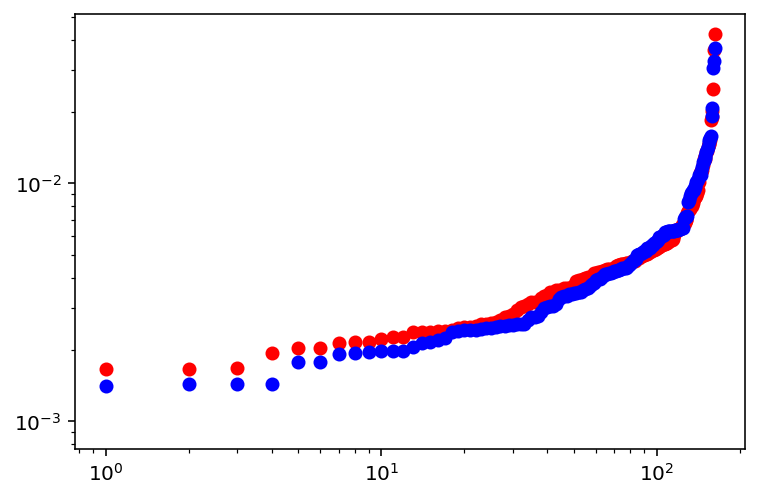

In [152]:
pagerankplot2 = pagerank_analysis(g_rn2)
plt.figure()
fig, ax = plt.subplots()
ax.plot(pagerankplot2[0], pagerankplot2[1], 'ro')
ax.plot(pagerankplot1[0], pagerankplot1[1], 'bo')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show

In [153]:
section_freq_graph2, section_time_graph2, len_arr2 = community_freq_analysis(g_rn2, c2, smallDict, 30)

## Strengthen Non - Sequences

In [154]:
g_rn3 = g_rn.copy()

In [155]:
for subgraph in sglst2:
    if len(list(subgraph.nodes())) - 1 != len(list(subgraph.edges())):
        #print("found")
        for node in list(subgraph.nodes):

            if len(list(subgraph.predecessors(node))) != len(list(g_rn3.predecessors(node))): #entrance node
                preds = set(g_rn3.predecessors(node)) - set(subgraph.predecessors(node))
                prededgelst=[]
                for p in preds:
                    prededgelst.append((p, node))
                g_rn3 = mnet.degree_increase(g_rn3, prededgelst, 2)
                #print("edges added")
                #print(prededgelst)
                    
                
        

In [156]:
nx.write_gexf(g_rn3, "../graphs/rn_communitychange3.gexf")

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

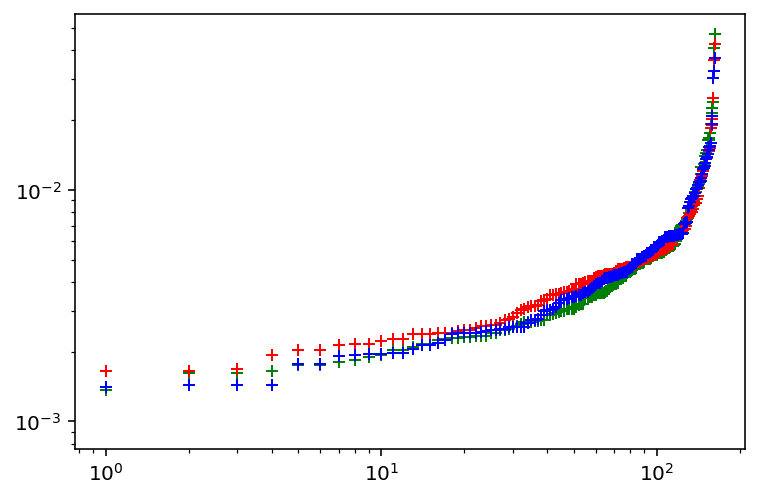

In [159]:
pagerankplot3 = pagerank_analysis(g_rn3)
plt.figure()
fig, ax = plt.subplots()
ax.plot(pagerankplot3[0], pagerankplot3[1], 'g+')
ax.plot(pagerankplot2[0], pagerankplot2[1], 'r+')
ax.plot(pagerankplot1[0], pagerankplot1[1], 'b+')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show

In [160]:
section_freq_graph3, section_time_graph3, len_arr3 = community_freq_analysis(g_rn3, c2, smallDict, 30)

## Strengthen Large Community Shift + Non-Sequences

In [161]:
g_rn4 = g_rn.copy()

In [162]:
g_rn4 = mnet.degree_increase(g_rn4, bridge13, 15)
g_rn4 = mnet.degree_increase(g_rn4, bridge12, 10)

In [163]:
for subgraph in sglst2:
    if len(list(subgraph.nodes())) - 1 != len(list(subgraph.edges())):
        #print("found")
        for node in list(subgraph.nodes):

            if len(list(subgraph.predecessors(node))) != len(list(g_rn4.predecessors(node))): #entrance node
                preds = set(g_rn4.predecessors(node)) - set(subgraph.predecessors(node))
                prededgelst=[]
                for p in preds:
                    prededgelst.append((p, node))
                g_rn2 = mnet.degree_increase(g_rn4, prededgelst, 2)
                #print("edges added")
                #print(prededgelst)
                    
                
        

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

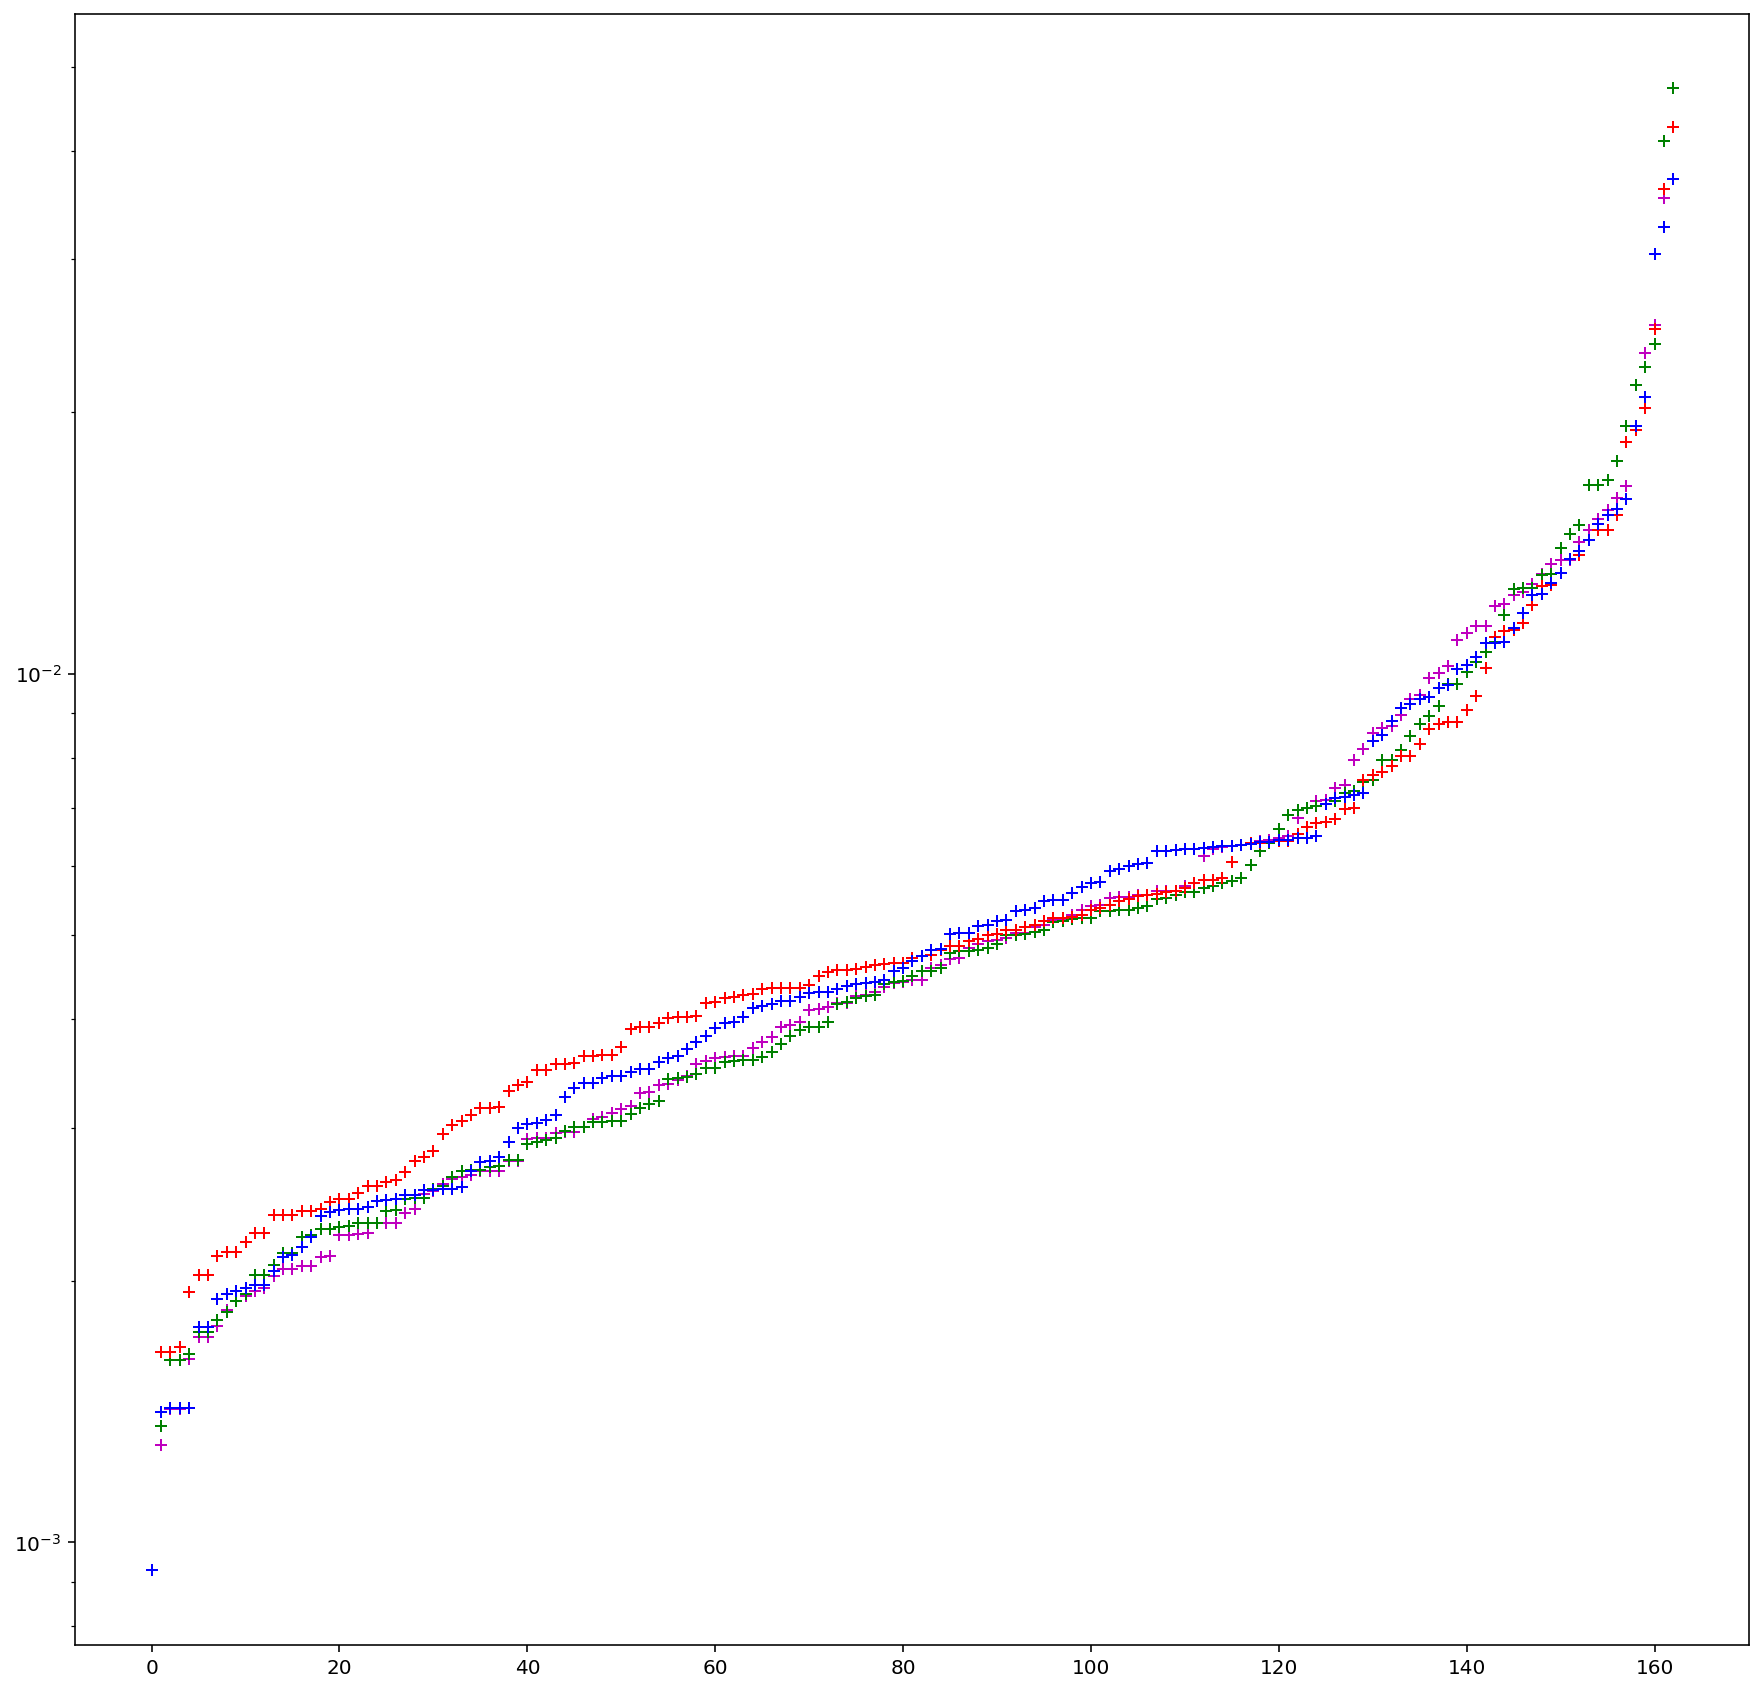

In [168]:
pagerankplot4 = pagerank_analysis(g_rn4)
plt.figure()
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(pagerankplot4[0], pagerankplot4[1], 'm+')
ax.plot(pagerankplot3[0], pagerankplot3[1], 'g+')
ax.plot(pagerankplot2[0], pagerankplot2[1], 'r+')
ax.plot(pagerankplot1[0], pagerankplot1[1], 'b+')
ax.set_yscale('log')
#ax.set_xscale('log')
plt.show

In [169]:
section_freq_graph4, section_time_graph4, len_arr4 = community_freq_analysis(g_rn4, c2, smallDict, 30)

/opt/anaconda3/envs/music-network-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


## Increase Probability of Staying in Level 2 Community

In [170]:
g_rn5 = g_rn.copy()

In [171]:
for subgraph in sglst2:
    g_rn5 = mnet.degree_increase(g_rn5, list(subgraph.edges()), 4)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

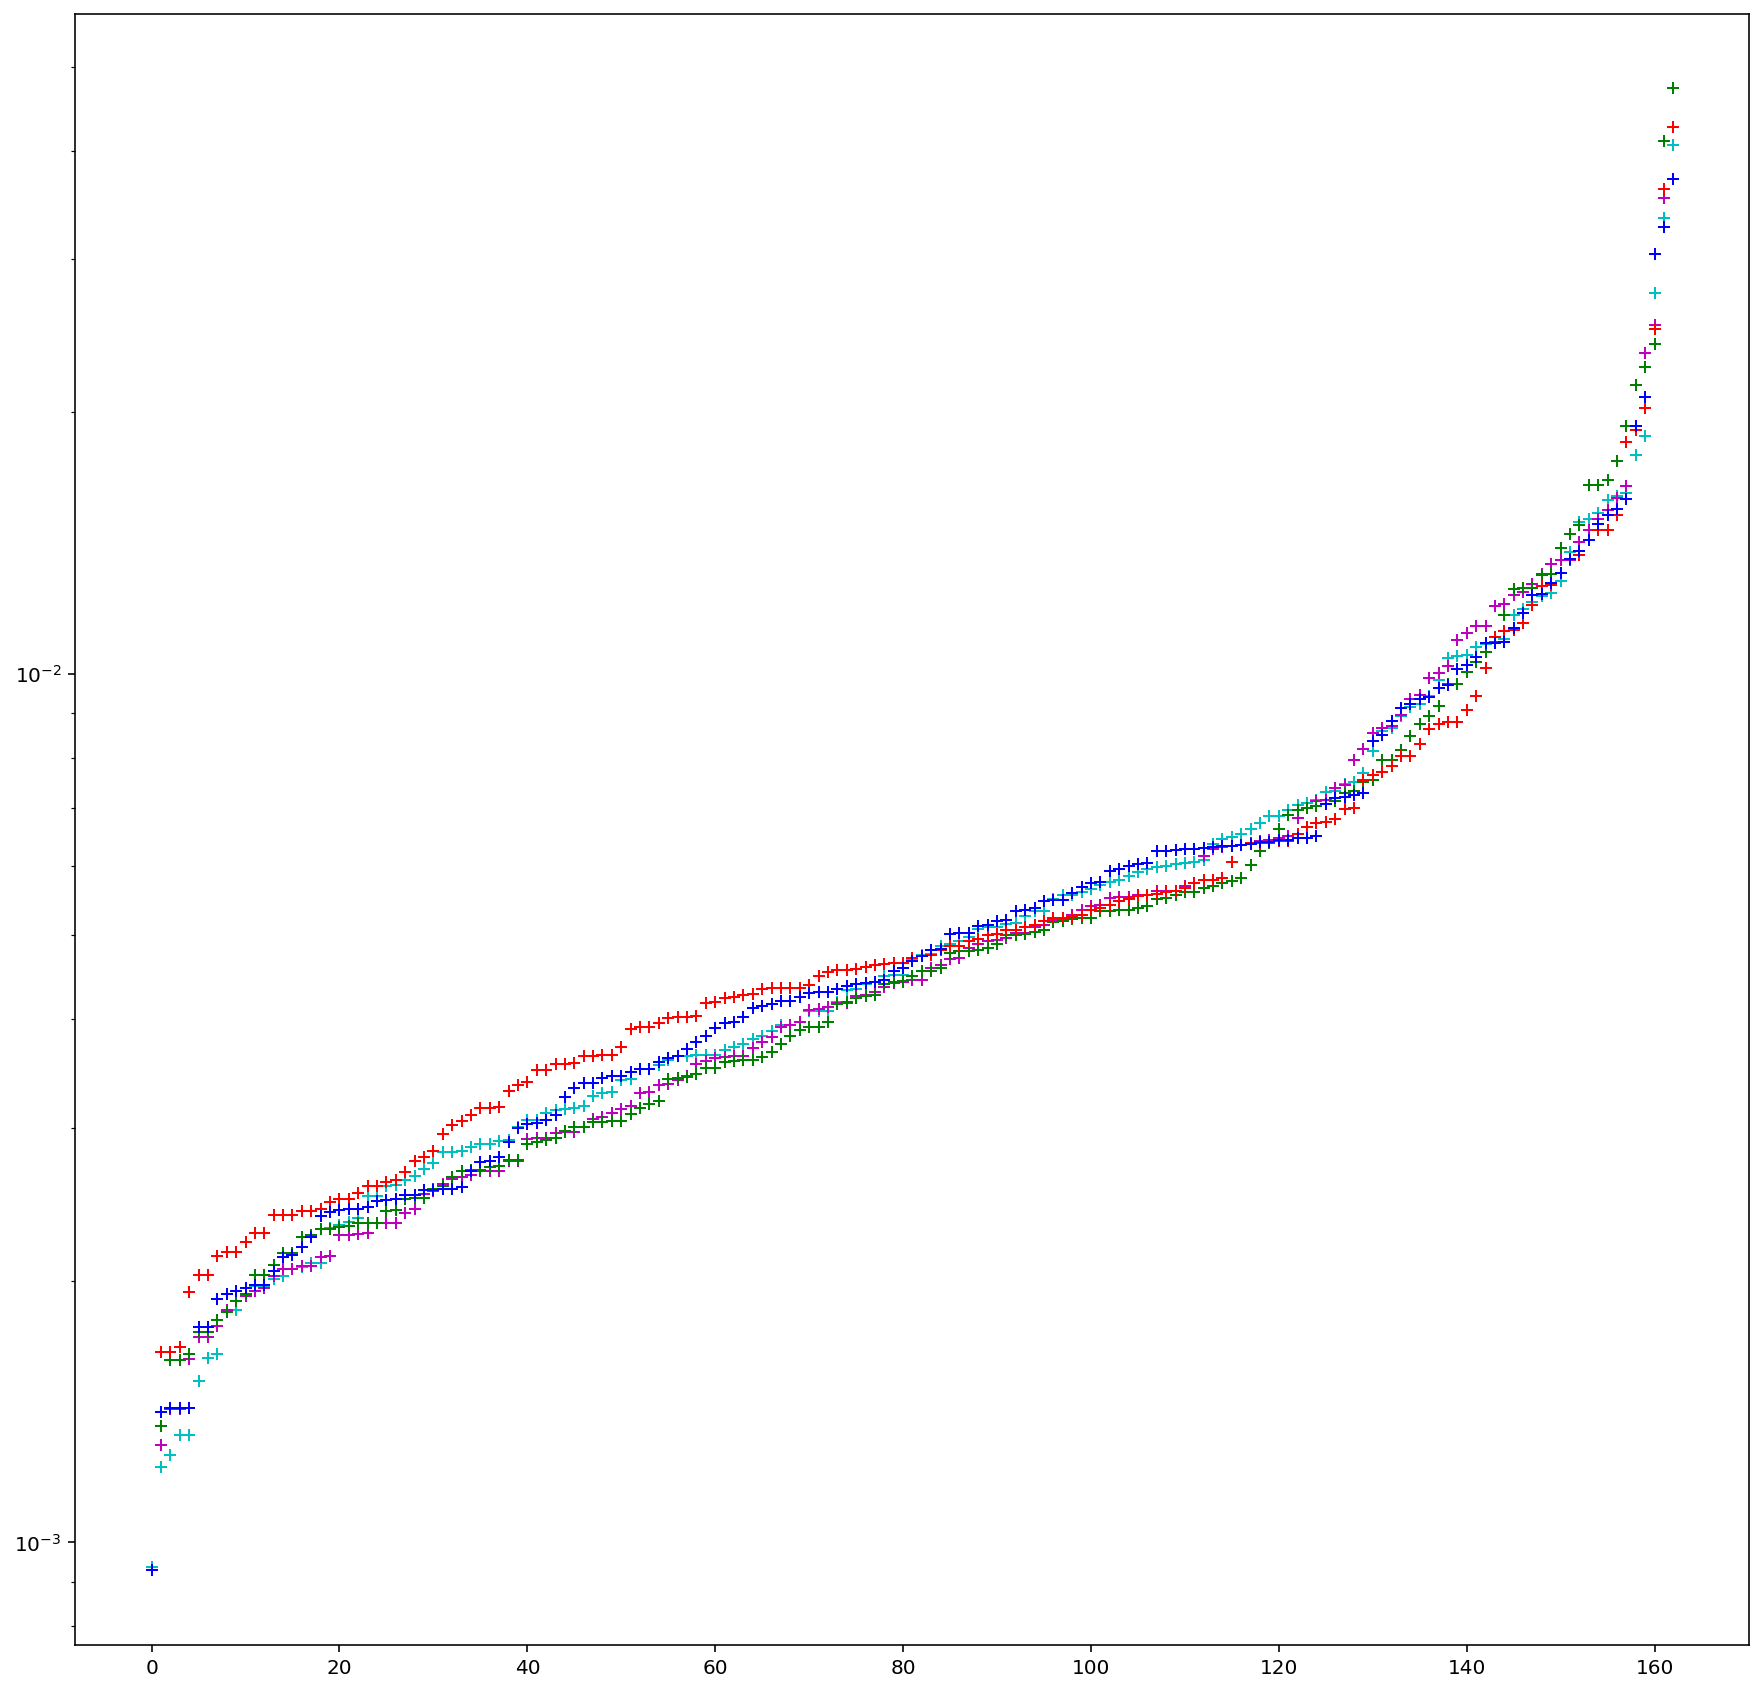

In [172]:
pagerankplot5 = pagerank_analysis(g_rn5)
plt.figure()
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(pagerankplot5[0], pagerankplot5[1], 'c+')
ax.plot(pagerankplot4[0], pagerankplot4[1], 'm+')
ax.plot(pagerankplot3[0], pagerankplot3[1], 'g+')
ax.plot(pagerankplot2[0], pagerankplot2[1], 'r+')
ax.plot(pagerankplot1[0], pagerankplot1[1], 'b+')
ax.set_yscale('log')
#ax.set_xscale('log')
plt.show

In [173]:
section_freq_graph5, section_time_graph5, len_arr5 = community_freq_analysis(g_rn5, c2, smallDict, 30)

## Analyze Original Graph

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

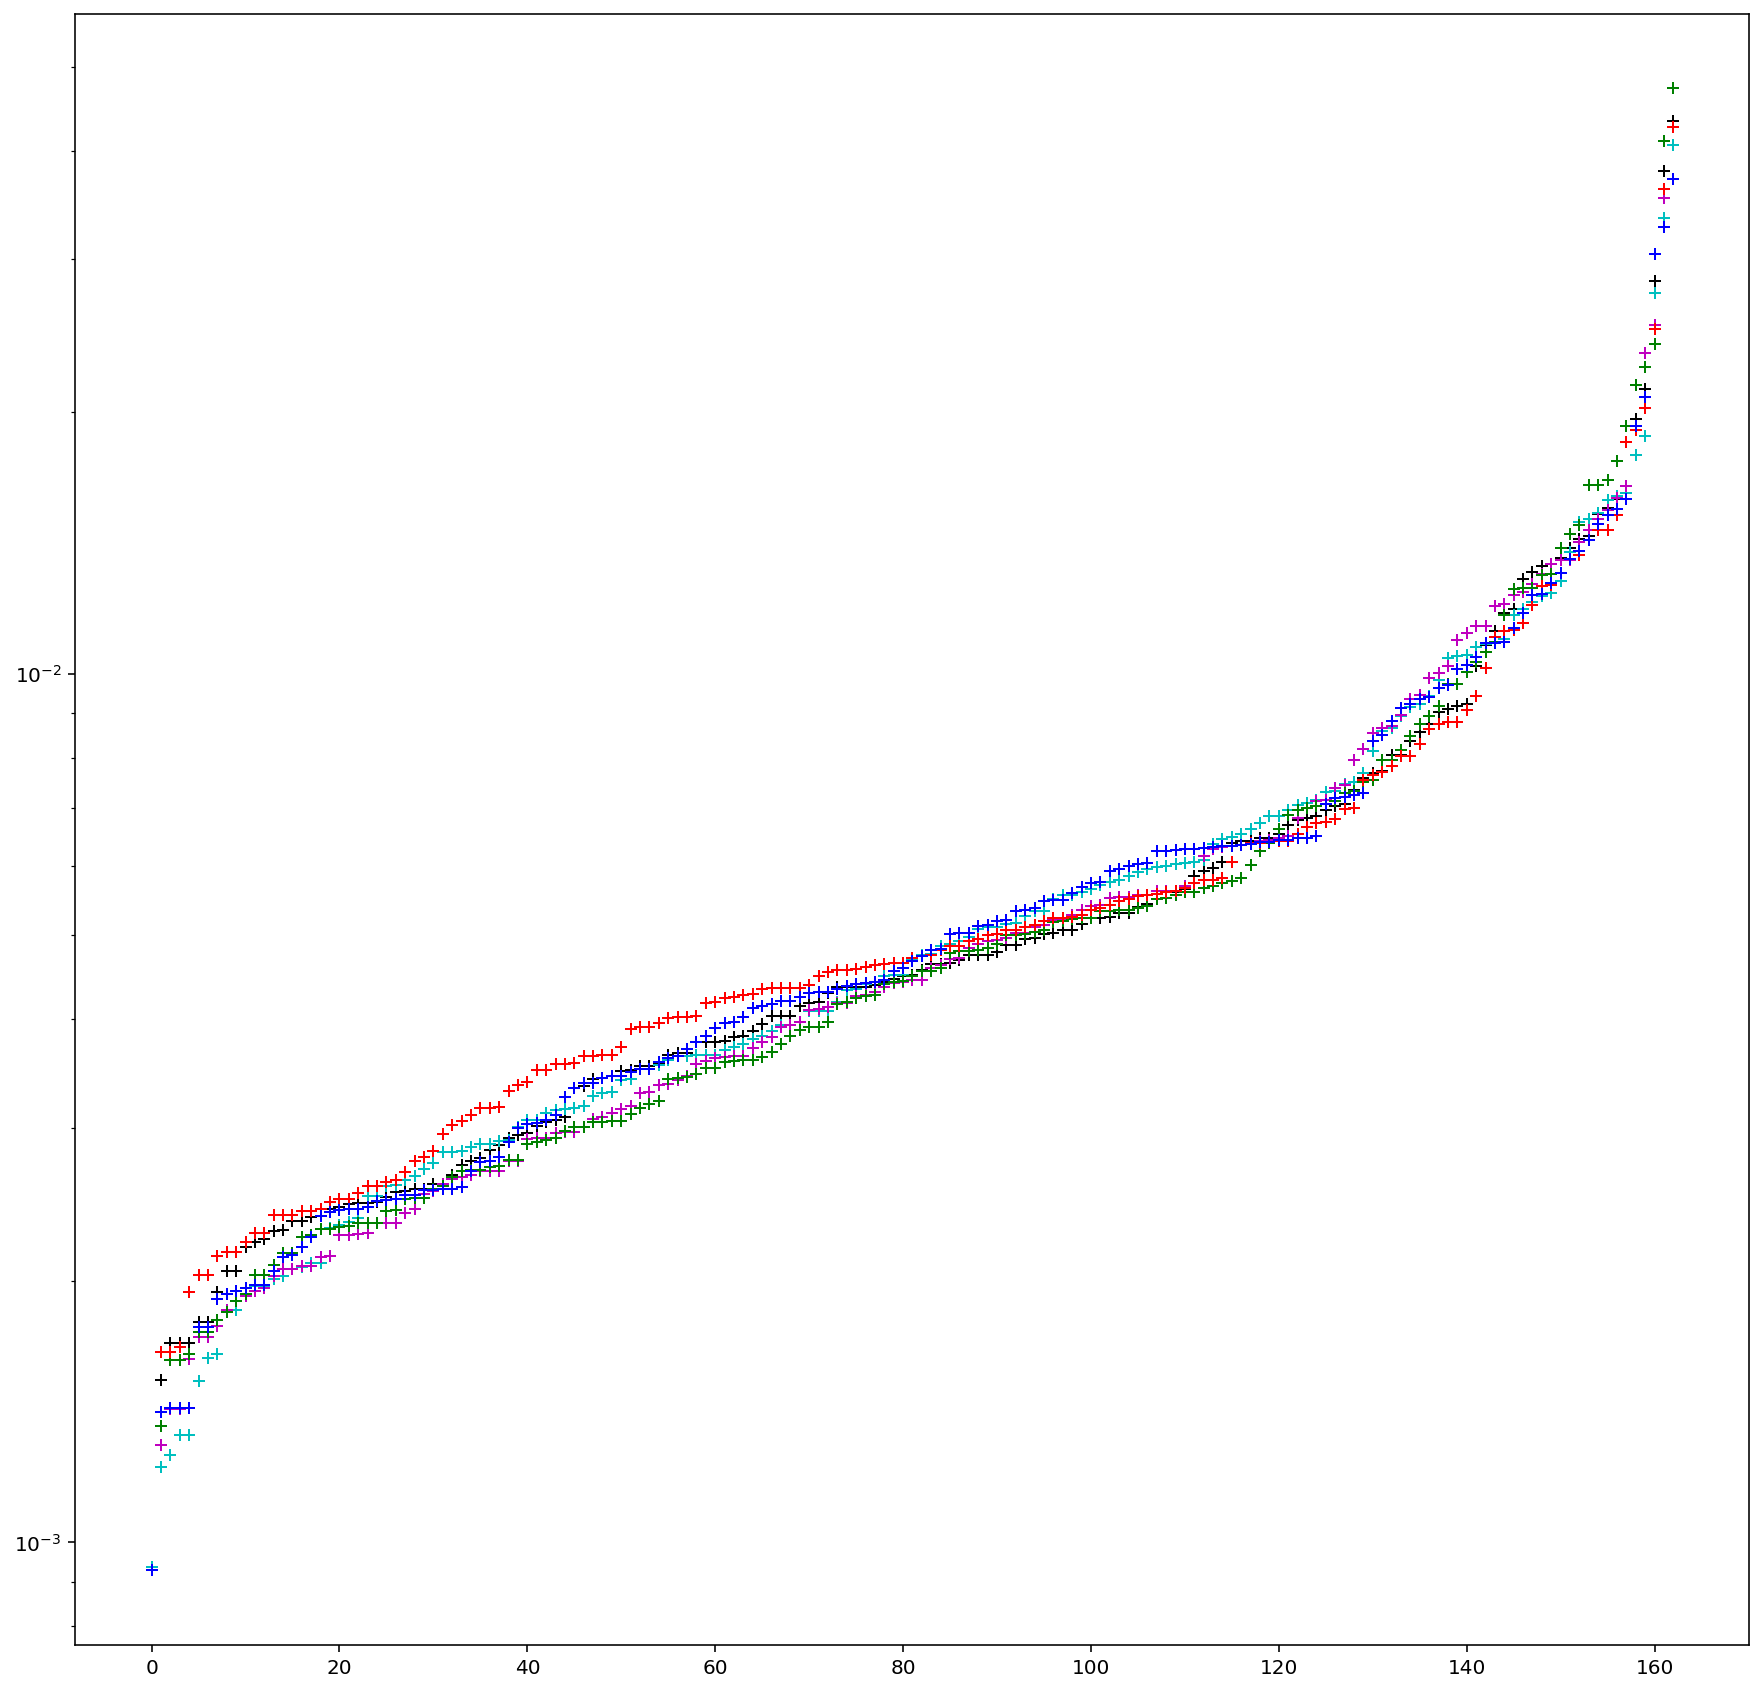

In [175]:
pagerankplot0 = pagerank_analysis(g_rn)
plt.figure()
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(pagerankplot0[0], pagerankplot0[1], 'k+')
ax.plot(pagerankplot5[0], pagerankplot5[1], 'c+')
ax.plot(pagerankplot4[0], pagerankplot4[1], 'm+')
ax.plot(pagerankplot3[0], pagerankplot3[1], 'g+')
ax.plot(pagerankplot2[0], pagerankplot2[1], 'r+')
ax.plot(pagerankplot1[0], pagerankplot1[1], 'b+')
ax.set_yscale('log')
#ax.set_xscale('log')
plt.show